In [2]:
from toolkit.logger import Logger
from toolkit.classes import DataFrameCreator
from toolkit.pytorch_tools import CustomImageDataLoader
from toolkit.pytorch_tools import AutoEncoder
from toolkit.pytorch_tools import AnomalyDetector
from torchvision.transforms import Compose
from torchvision.transforms import Resize
from torchvision.transforms import Normalize
from torchvision.transforms import ToPILImage
from torchvision.transforms import ToTensor
from torchvision.transforms import RandomVerticalFlip
from torchvision.transforms import RandomRotation
from torchvision.transforms import RandomErasing

# from torchsummary import summary

from pathlib import Path

import torch

In [3]:
logger = Logger("main").get_logger()

NUM_CORES = 8
DEVICE = "cpu"

In [4]:
data = DataFrameCreator()
data_folder = Path("./data")

samples = ["sd1_sample"]

In [5]:
for sample in samples:
    data.load_dataset(
        sample_dir=data_folder / sample, labels={"extracted_imgs": 0}
    )
data.split_dataset()
data.info()
data["dataset"].head()

[    INFO    ] Images loaded from data/sd1_sample with label extracted_imgs
[    INFO    ] Name :          dataset
[    INFO    ] Labels:         {'extracted_imgs': 8733}
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc')
[    INFO    ] Shape:          (8733, 5)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          train
[    INFO    ] Labels:         {'extracted_imgs': 6113}
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc')
[    INFO    ] Shape:          (6113, 5)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          validation
[    INFO    ] Labels:         {'extracted_imgs': 1746}
[    INFO    ] Columns:        ('img_dir', 'img_file', 'img', 'label', 'label_enc')
[    INFO    ] Shape:          (1746, 5)
[    INFO    ] File types:     ('jpg',)
[    INFO    ] Name :          test
[    INFO    ] Labels:         {'extracted_imgs': 874}
[    INFO    ] Columns:        ('img_dir', 'img_file

,img_dir,img_file,img,label,label_enc
0,data/sd1_sample/extracted_imgs,img_00000.jpg,data/sd1_sample/extracted_imgs/img_00000.jpg,extracted_imgs,0
1,data/sd1_sample/extracted_imgs,img_00001.jpg,data/sd1_sample/extracted_imgs/img_00001.jpg,extracted_imgs,0
2,data/sd1_sample/extracted_imgs,img_00002.jpg,data/sd1_sample/extracted_imgs/img_00002.jpg,extracted_imgs,0
3,data/sd1_sample/extracted_imgs,img_00003.jpg,data/sd1_sample/extracted_imgs/img_00003.jpg,extracted_imgs,0
4,data/sd1_sample/extracted_imgs,img_00004.jpg,data/sd1_sample/extracted_imgs/img_00004.jpg,extracted_imgs,0


In [6]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# input_size = (64, 160)
input_size = (288, 704)

transform = {
    "train": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
            RandomVerticalFlip(p=0.5),
            RandomRotation((-5, 5)),
            RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0),
        ]
    ),
    "validation": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
        ]
    ),
    "test": Compose(
        [
            ToPILImage(),
            ToTensor(),
            Resize(size=input_size),
            Normalize(mean=mean, std=std),
        ]
    ),
}
target_transform = {
    "train": None,
    "validation": None,
    "test": None,
}

loader = CustomImageDataLoader(
    dataset=data,
    image_col="img",
    label_col="label_enc",
    transform=transform,
    target_transform=target_transform,
    num_workers=NUM_CORES,
)
loader.create_dataloaders(batch_size=8)

[    INFO    ] CustomImageDataSet created
[  WARNING   ] Setting dataloader subprocesses manually to 8
[    INFO    ] Dataloaders created


In [7]:
model = AutoEncoder(name="vgg19_vgg19", encoder_name="VGG19", encoder_weights="IMAGENET1K_V1")
model.init_device(device=DEVICE)

[    INFO    ] Using matching filters: [512]
[    INFO    ] Model filename: results/vgg19_vgg19/20230513_152227.pth
[    INFO    ] Results filename: /results/vgg19_vgg19/20230513_152227.csv
[    INFO    ] AutoEncoder constructed: vgg19_vgg19
[    INFO    ] AutoEncoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [7]:
# summary(model, input_size=(3, *input_size), device="cpu")

In [8]:
model_to_load = Path("./results/vgg19_vgg19/20230510_172958.pth")
# model_to_load = None
if model_to_load:
    model.load(model_file=model_to_load)
    model.results.load(filename=model_to_load.with_suffix(".csv"))

[    INFO    ] Model loaded from: /results/vgg19_vgg19/20230510_172958.pth
[    INFO    ] Results loaded from /results/vgg19_vgg19/20230510_172958.csv


In [10]:
epochs = 10

model.train_net(epochs=epochs, train_loader=loader["train"], validation_loader=loader["validation"])

[    INFO    ] Model training started


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   14 Loss:  0.0348 Validation loss:  0.0367   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   15 Loss:  0.0340 Validation loss:  0.0349   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   16 Loss:  0.0332 Validation loss:  0.0345   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   17 Loss:  0.0327 Validation loss:  0.0355   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   18 Loss:  0.0320 Validation loss:  0.0332   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   19 Loss:  0.0314 Validation loss:  0.0323   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   20 Loss:  0.0309 Validation loss:  0.0321   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   21 Loss:  0.0304 Validation loss:  0.0318   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   22 Loss:  0.0300 Validation loss:  0.0312   


  0%|          | 0/765 [00:00<?, ?it/s]

[    INFO    ] Epoch:   23 Loss:  0.0294 Validation loss:  0.0306   


In [9]:
model.results.data

,loss,validation_loss
epochs,,
0,0.163732,0.082894
1,0.071995,0.066008
2,0.058969,0.060581
3,0.052913,0.052291
4,0.048988,0.049054
5,0.045978,0.046216
6,0.043868,0.043940
7,0.042014,0.042486
8,0.040650,0.041278


In [12]:
model.save()
model.results.save()

[    INFO    ] Model saved to: results/vgg19_vgg19/20230510_172958.pth
[    INFO    ] Results saved to: results/vgg19_vgg19/20230510_172958.csv


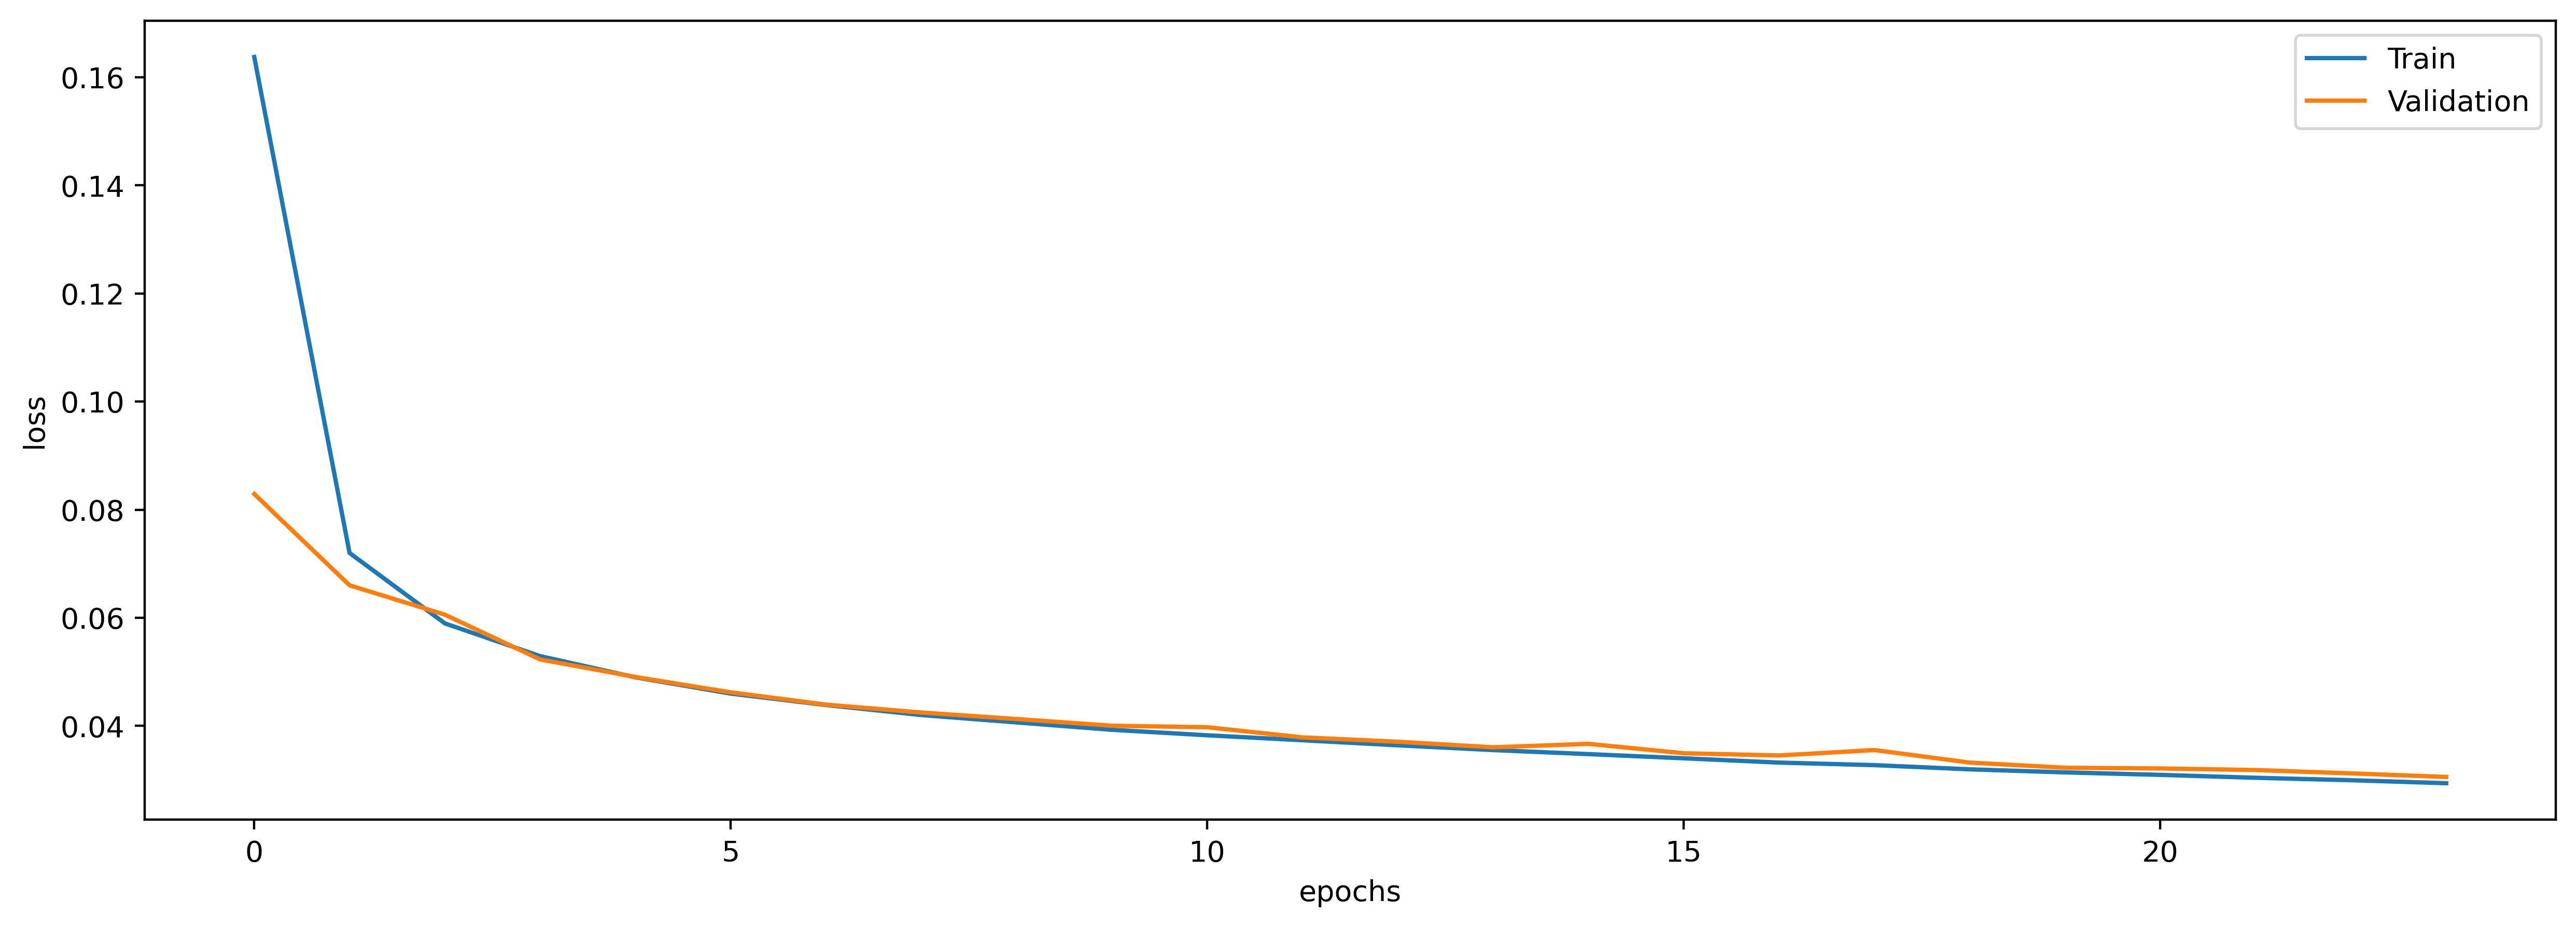

In [11]:
model.results.plot()

  0%|          | 0/100 [00:00<?, ?it/s]

[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.018s...
[t-SNE] Computed neighbors for 100 samples in 0.626s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 158.887296
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.970627
[t-SNE] KL divergence after 300 iterations: 0.103091
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.004s...
[t-SNE] Computed neighbors for 100 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 45397.647183
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.955742
[t-SNE] KL divergence after 300 iterations: 0.164145
[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.003s...
[t-SNE] Computed neighbors for 100 samples in 0.076s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 45478.559590
[t-SNE] KL divergence after 250 

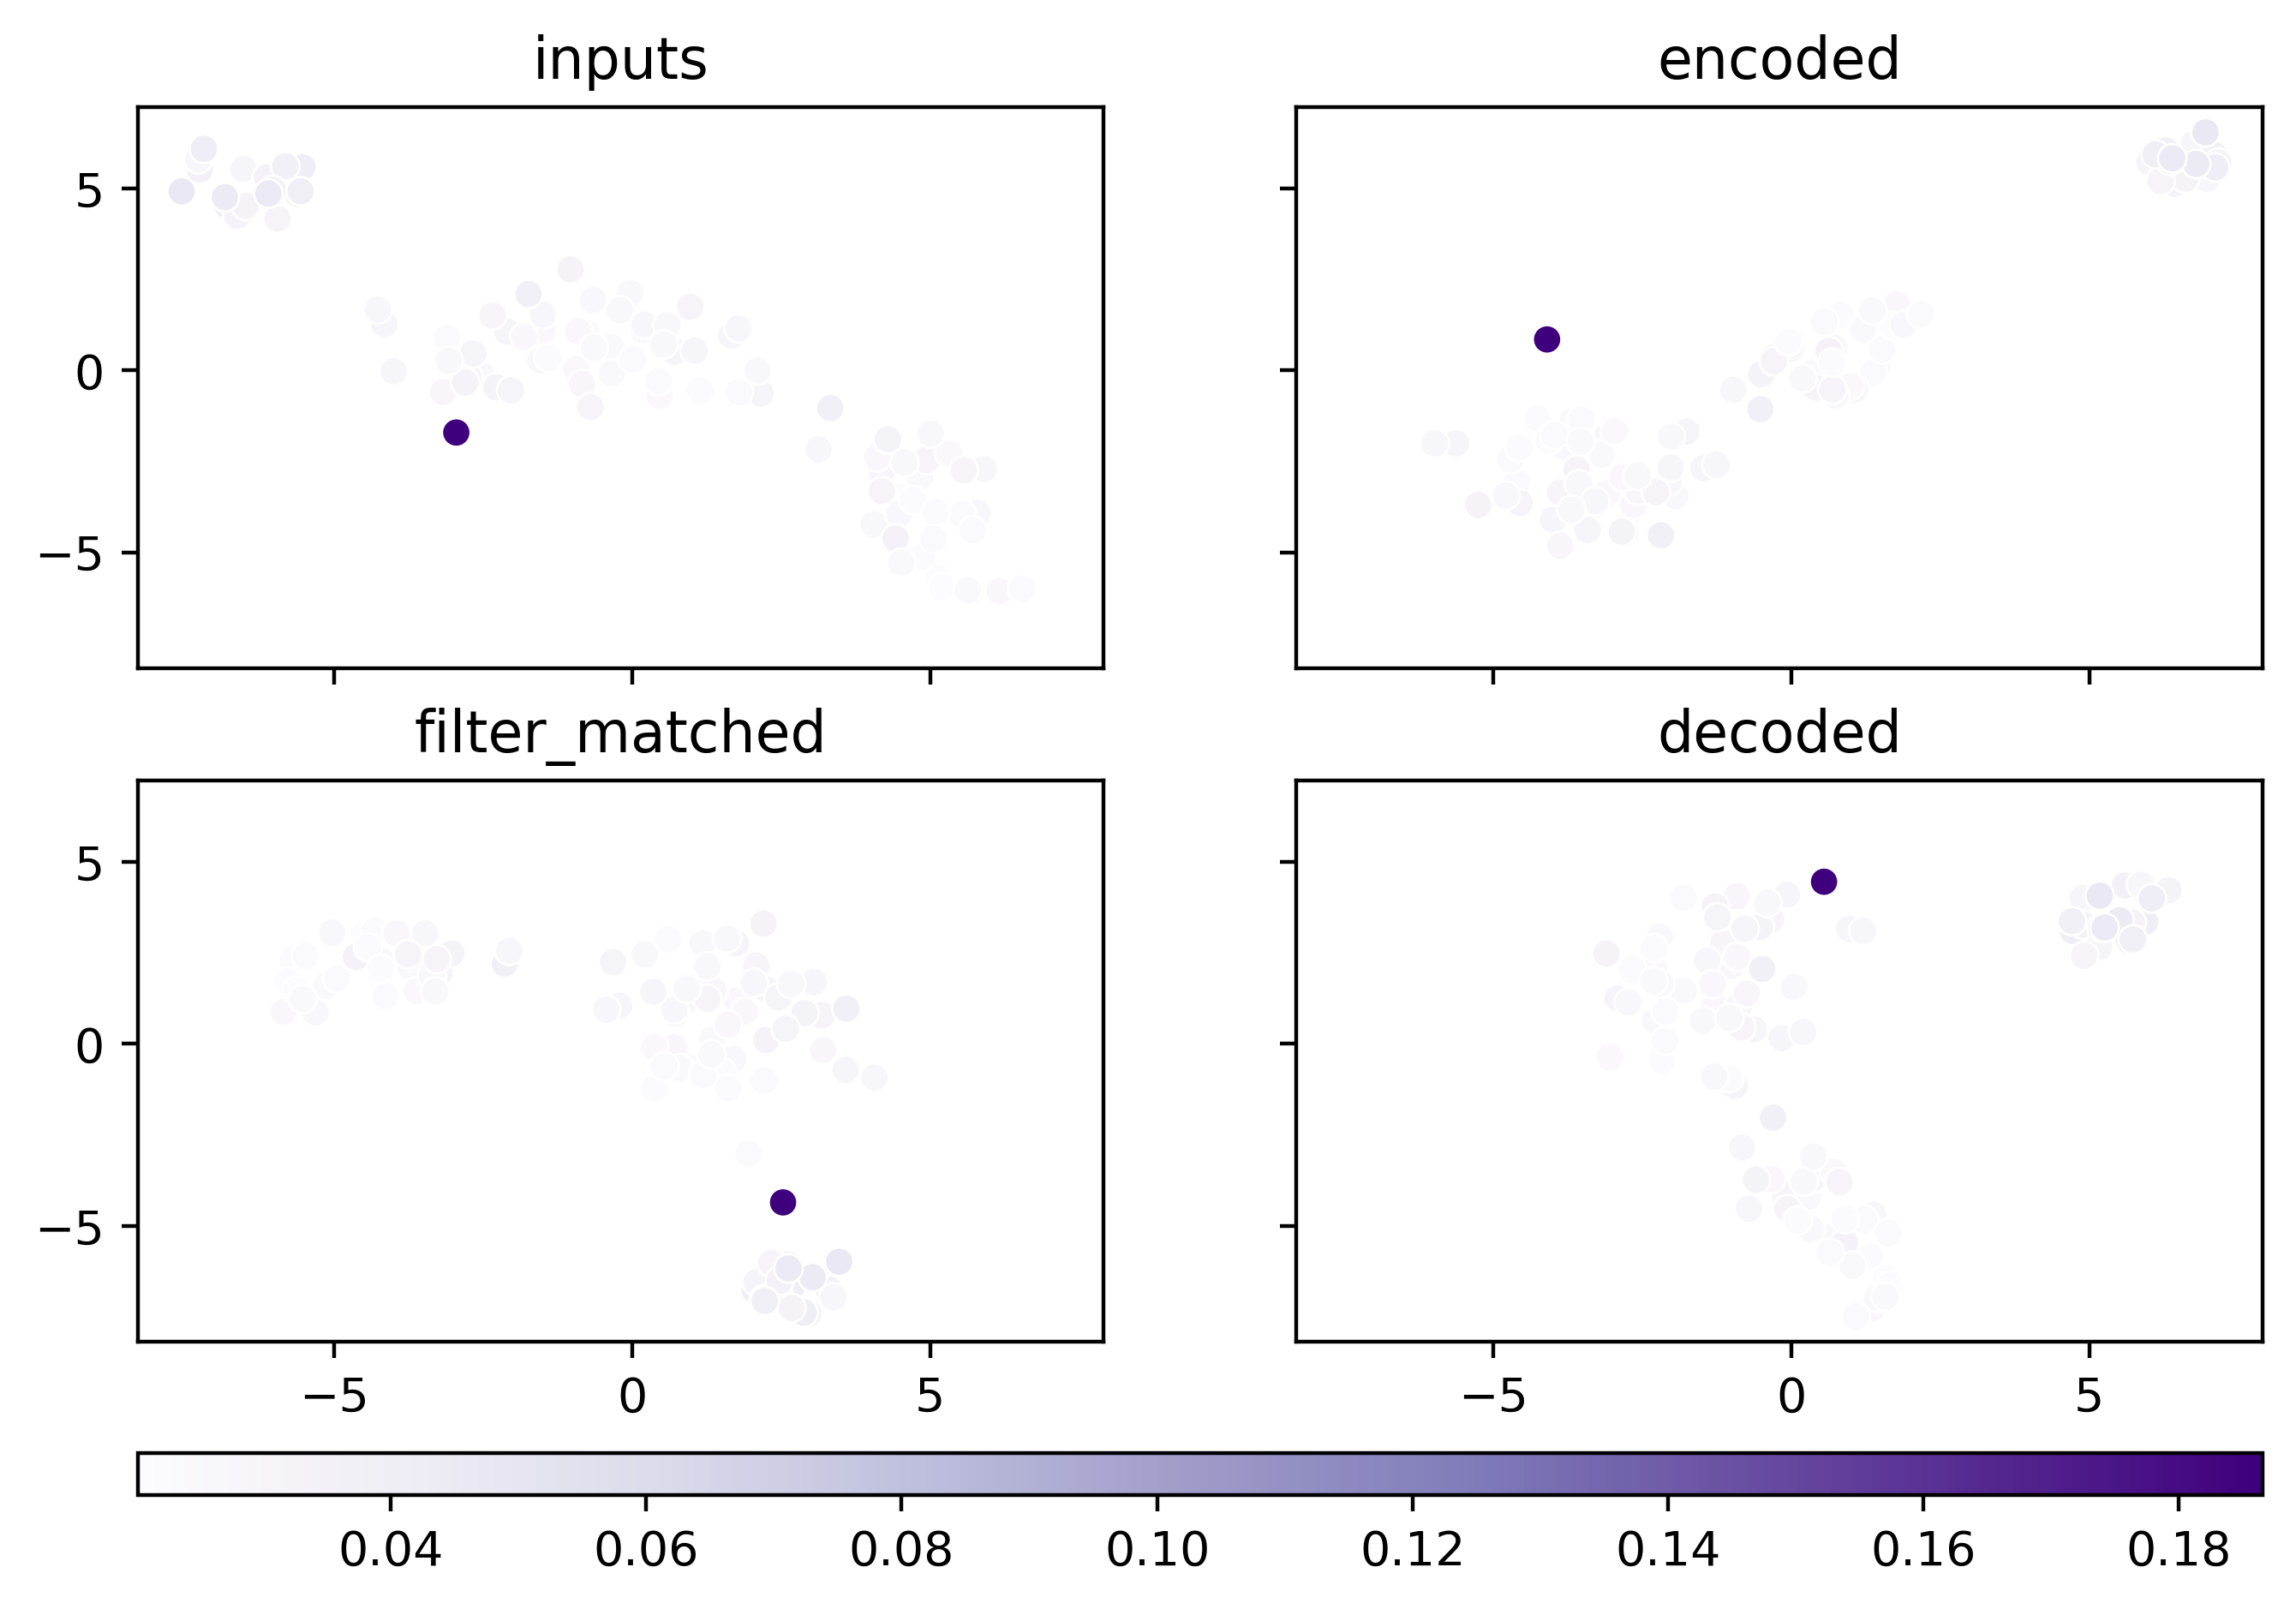

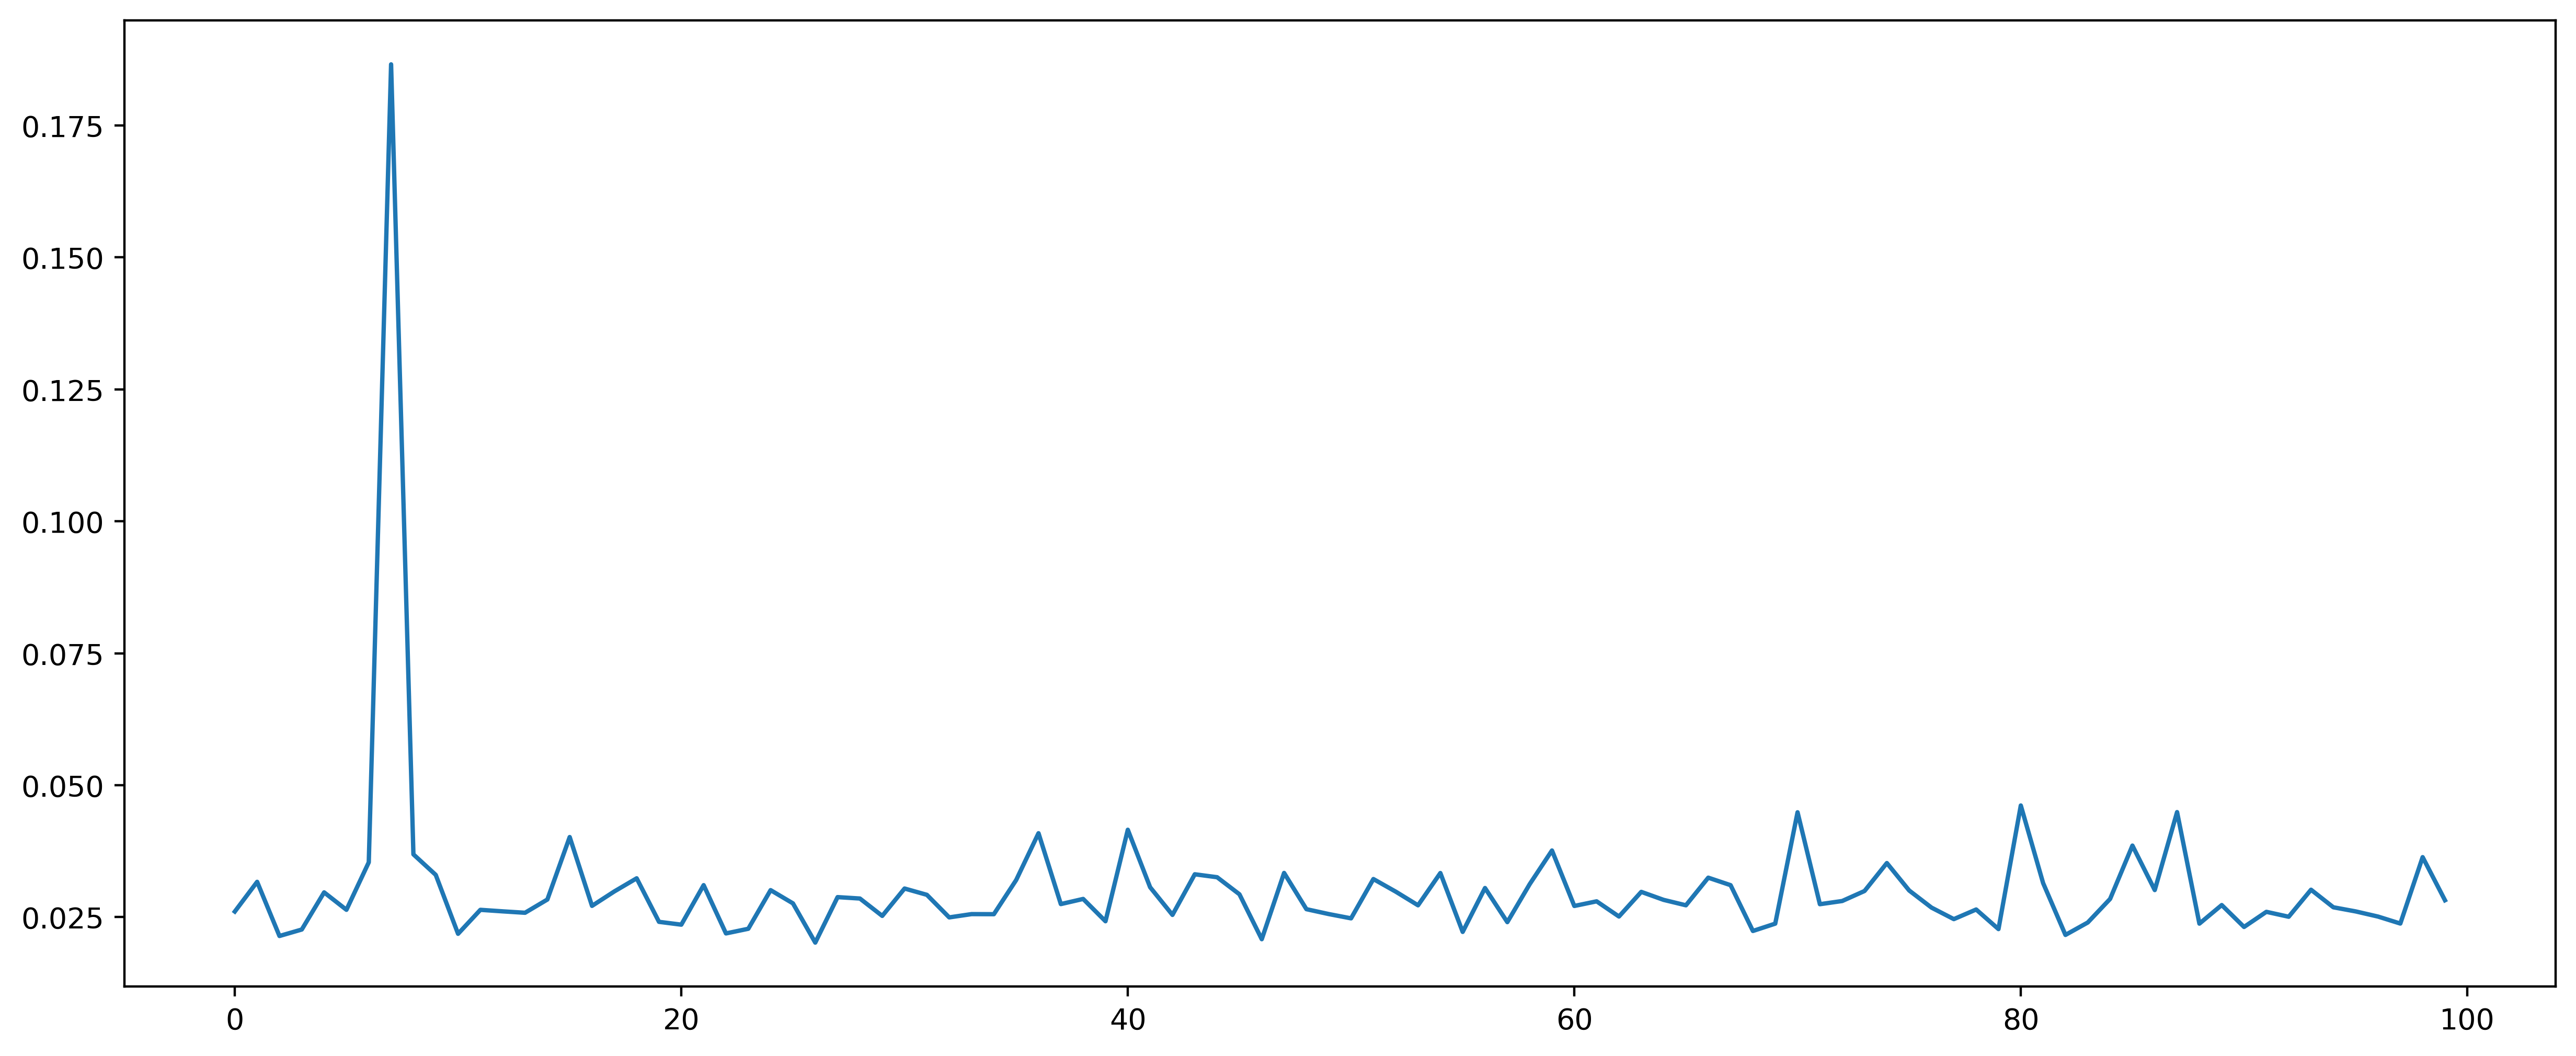

In [10]:
feature_vectors, loss = model.calc_feature_vectors(dataset=data["test"], transform=transform["test"])
model.plot_feature_vectors(feature_vectors=feature_vectors, loss=loss)

In [11]:
import numpy as np
idxs = np.argsort(loss)[::-1][:3]
idxs, np.sort(loss)[::-1][:3]

(array([ 7, 80, 87]), array([0.18656102, 0.04615151, 0.04489847]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


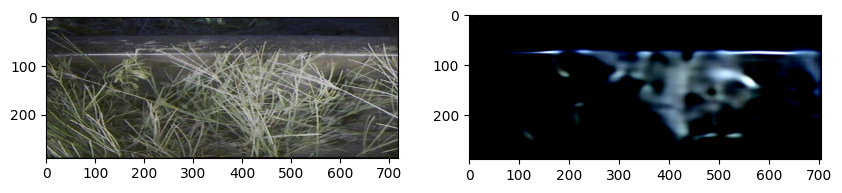

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


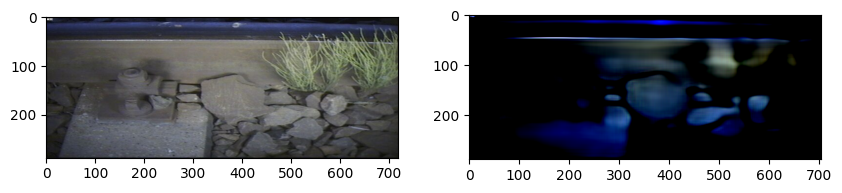

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


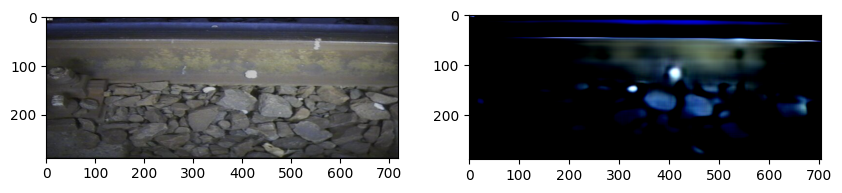

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


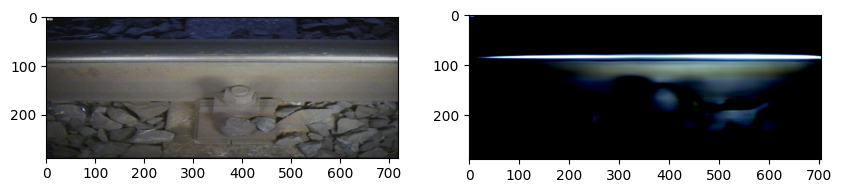

In [14]:
_ = model.predict(images=data["test"].img.iloc[idxs], transform=transform["test"], plot=True)

In [24]:
detector = AnomalyDetector(detector_type="IsolationForest", n_jobs=NUM_CORES)
detector.fit(X=feature_vectors[1])
anomalies = detector.predict(X=feature_vectors[1])
data["test"].show_images(idxs=anomalies[anomalies["outlier"] == True]["img_idx"])